In [1]:
import numpy as np
import scipy as sp
import datajoint as dj
import matplotlib.pyplot as plt

In [2]:
dj.config['database.host'] = 'mesoscale-activity.datajoint.io'

In [4]:
from pipeline import lab, experiment, tracking, ephys, psth
from pipeline import plot
from pipeline.plot import behavior_plot, unit_characteristic_plot

Please enter DataJoint username: shenshan
Please enter DataJoint password: ········
Connecting shenshan@mesoscale-activity.datajoint.io:3306


# Three major schemas: lab, experiment, and ephys

# Digram for the schema ***lab***: meta data

**Table tiers**:
<br>
Manual table: green box
<br>
Lookup table: gray box
<br>
Imported table: blue oval
<br>
Computed table: red circle
<br>
Part table: plain text

**Dependencies**:
<br>
One-to-one primary: thick solid line
<br>
One-to-many primary: thin solid line
<br>
Secondary foreign key reference: dashed line

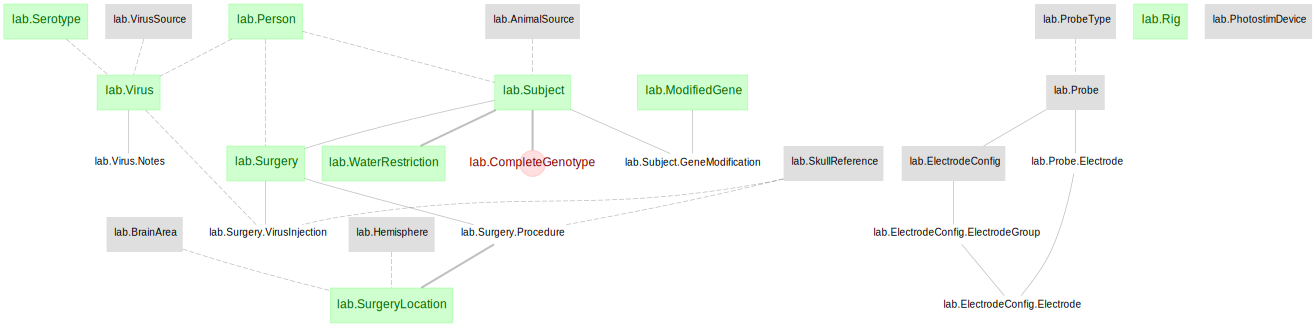

In [38]:
dj.ERD(lab)

# Diagram of part of the ***experiment*** schema: behavior information

In [10]:
behav_erd = (dj.ERD(experiment.SessionTrial) - 1 
             + (dj.ERD(experiment.BrainLocation)-1) 
             + (dj.ERD(experiment.BehaviorTrial) + 1 - 1) 
             + (dj.ERD(experiment.PhotostimTrial) + 1 - 1)) 

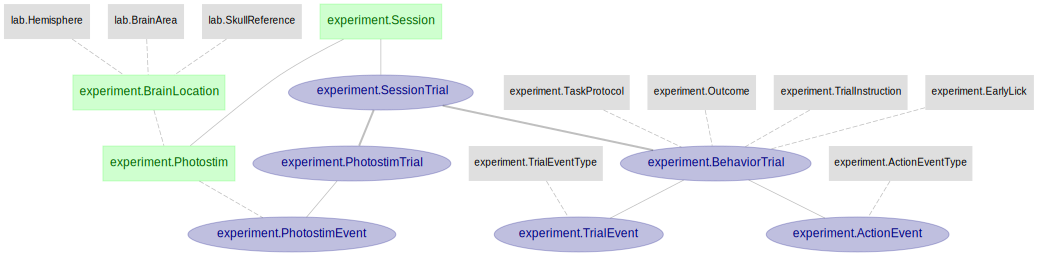

In [11]:
behav_erd

# Diagram of part of the ***ephys*** schema: ephys data

In [12]:
ephys_erd = ((dj.ERD(ephys.Unit)-2) + dj.ERD(ephys.TrialSpikes)
             + (dj.ERD(experiment.BrainLocation)-1)
             + dj.ERD(ephys.ProbeInsertion.InsertionLocation)
             + dj.ERD(psth.UnitSelectivity) + (dj.ERD(psth.PeriodSelectivity) - 1))

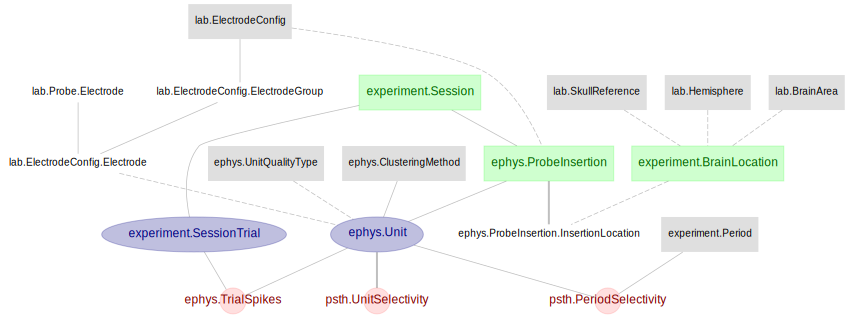

In [13]:
ephys_erd

# Diagram of ***unit*** 

In [14]:
unit_erd = (dj.ERD(ephys.Unit) - 1) + (dj.ERD(ephys.Unit) + 1)

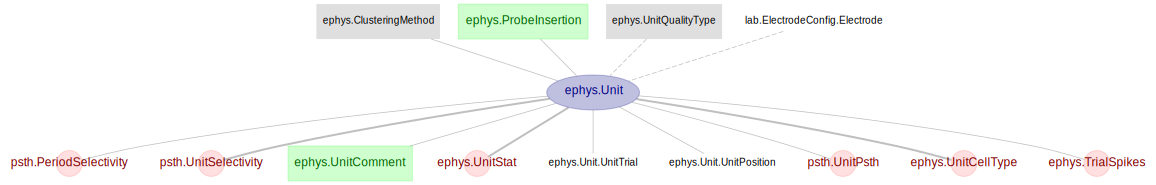

In [15]:
unit_erd

# Getting the detailed definition of a table - .describe()

In [16]:
ephys.Unit.describe();

# Sorted unit
-> ephys.ProbeInsertion
-> ephys.ClusteringMethod
unit                 : smallint                     
---
unit_uid             : int                          # unique across sessions/animals
-> ephys.UnitQualityType
-> lab.ElectrodeConfig.Electrode
unit_posx            : double                       # (um) estimated x position of the unit relative to probe's (0,0)
unit_posy            : double                       # (um) estimated y position of the unit relative to probe's (0,0)
spike_times          : longblob                     # (s) from the start of the first data point used in clustering
unit_amp             : double                       
unit_snr             : double                       
waveform             : blob                         # average spike waveform



# Browsing of data - queries

### Query all subjects

In [17]:
lab.Subject()

subject_id institution 6 digit animal ID,username,cage_number institution 6 digit animal ID,date_of_birth format: yyyy-mm-dd,sex,animal_source
412330,daveliu,154522,2017-12-05,M,Jackson labs
412753,daveliu,154570,2017-12-07,M,Jackson labs
413950,daveliu,155585,2017-12-21,M,Jackson labs
418279,daveliu,155593,2018-02-02,M,Jackson labs
428047,daveliu,158986,2018-05-16,M,Jackson labs
428048,daveliu,158987,2018-05-16,M,Jackson labs
432570,daveliu,161126,2018-06-28,M,Jackson labs
432572,daveliu,161125,2018-06-28,M,Jackson labs
432998,daveliu,160920,2018-07-02,M,Jackson labs
435884,daveliu,161908,2018-08-06,M,Jackson labs


## Restriction  ***&***: filtering data

### Restriction: Query one subject

In [32]:
# restrict by string
lab.Subject & 'subject_id=412330'

subject_id institution 6 digit animal ID,username,cage_number institution 6 digit animal ID,date_of_birth format: yyyy-mm-dd,sex,animal_source
412330,daveliu,154522,2017-12-05,M,Jackson labs


In [33]:
# restrict by dictionary
lab.Subject & {'subject_id': 412330}

subject_id institution 6 digit animal ID,username,cage_number institution 6 digit animal ID,date_of_birth format: yyyy-mm-dd,sex,animal_source
412330,daveliu,154522,2017-12-05,M,Jackson labs


In [34]:
lab.Subject & {'sex': 'm'}

subject_id institution 6 digit animal ID,username,cage_number institution 6 digit animal ID,date_of_birth format: yyyy-mm-dd,sex,animal_source
412330,daveliu,154522,2017-12-05,M,Jackson labs
412753,daveliu,154570,2017-12-07,M,Jackson labs
413950,daveliu,155585,2017-12-21,M,Jackson labs
418279,daveliu,155593,2018-02-02,M,Jackson labs
428047,daveliu,158986,2018-05-16,M,Jackson labs
428048,daveliu,158987,2018-05-16,M,Jackson labs
432570,daveliu,161126,2018-06-28,M,Jackson labs
432572,daveliu,161125,2018-06-28,M,Jackson labs
432998,daveliu,160920,2018-07-02,M,Jackson labs
435884,daveliu,161908,2018-08-06,M,Jackson labs


### Restriction: Query subjects born after a date

In [21]:
lab.Subject & 'date_of_birth > "2018-08-23"'

subject_id institution 6 digit animal ID,username,cage_number institution 6 digit animal ID,date_of_birth format: yyyy-mm-dd,sex,animal_source
439457,daveliu,163374,2018-09-16,M,Jackson labs
440010,daveliu,163782,2018-09-24,M,Jackson labs


### Restriction: subjects within a range of dates

In [26]:
lab.Subject & 'date_of_birth between "2018-01-01" and "2018-08-23"'

subject_id institution 6 digit animal ID,username,cage_number institution 6 digit animal ID,date_of_birth format: yyyy-mm-dd,sex,animal_source
418279,daveliu,155593,2018-02-02,M,Jackson labs
428047,daveliu,158986,2018-05-16,M,Jackson labs
428048,daveliu,158987,2018-05-16,M,Jackson labs
432570,daveliu,161126,2018-06-28,M,Jackson labs
432572,daveliu,161125,2018-06-28,M,Jackson labs
432998,daveliu,160920,2018-07-02,M,Jackson labs
435884,daveliu,161908,2018-08-06,M,Jackson labs


### Restriction: Query subjects on multiple attributes

In [28]:
lab.Subject & 'date_of_birth > "2018-01-01"' & 'cage_number > "160000"'

subject_id institution 6 digit animal ID,username,cage_number institution 6 digit animal ID,date_of_birth format: yyyy-mm-dd,sex,animal_source
432570,daveliu,161126,2018-06-28,M,Jackson labs
432572,daveliu,161125,2018-06-28,M,Jackson labs
432998,daveliu,160920,2018-07-02,M,Jackson labs
435884,daveliu,161908,2018-08-06,M,Jackson labs
439457,daveliu,163374,2018-09-16,M,Jackson labs
440010,daveliu,163782,2018-09-24,M,Jackson labs


### Restriction: Query subjects restricted by other tables

In [30]:
# subjects with Ephys recording
lab.Subject & ephys.ProbeInsertion

subject_id institution 6 digit animal ID,username,cage_number institution 6 digit animal ID,date_of_birth format: yyyy-mm-dd,sex,animal_source
412330,daveliu,154522,2017-12-05,M,Jackson labs
412753,daveliu,154570,2017-12-07,M,Jackson labs
413950,daveliu,155585,2017-12-21,M,Jackson labs
432570,daveliu,161126,2018-06-28,M,Jackson labs
432572,daveliu,161125,2018-06-28,M,Jackson labs
432998,daveliu,160920,2018-07-02,M,Jackson labs
435884,daveliu,161908,2018-08-06,M,Jackson labs
440010,daveliu,163782,2018-09-24,M,Jackson labs


In [31]:
# subjects without Ephys recording
lab.Subject - ephys.ProbeInsertion

subject_id institution 6 digit animal ID,username,cage_number institution 6 digit animal ID,date_of_birth format: yyyy-mm-dd,sex,animal_source
418279,daveliu,155593,2018-02-02,M,Jackson labs
428047,daveliu,158986,2018-05-16,M,Jackson labs
428048,daveliu,158987,2018-05-16,M,Jackson labs
439457,daveliu,163374,2018-09-16,M,Jackson labs


## Join *:  gather information from different tables

In [41]:
experiment.Session * ephys.ProbeInsertion

subject_id institution 6 digit animal ID,session session number,insertion_number,session_date,username,rig,probe unique identifier for this model of probe (e.g. part number),electrode_config_name user friendly name
412330,15,1,2018-07-16,daveliu,RRig,15131808323,npx_first384
412330,15,2,2018-07-16,daveliu,RRig,15131808323,npx_first384
412753,41,1,2018-07-10,daveliu,RRig,15131808323,npx_first384
412753,41,2,2018-07-10,daveliu,RRig,15131808323,npx_first384
413950,20,1,2018-10-22,daveliu,RRig,15131808323,npx_first384
413950,20,2,2018-10-22,daveliu,RRig,15131808323,npx_first384
413950,21,1,2018-10-23,daveliu,RRig,15131808323,npx_first384
413950,21,2,2018-10-23,daveliu,RRig,15131808323,npx_first384
432570,13,2,2018-10-22,daveliu,RRig,15131808323,npx_first384
432572,9,2,2018-11-20,daveliu,RRig,15131808323,npx_first384


## Projection .proj(): focus on attributes of interest

In [51]:
lab.Subject.proj()

subject_id institution 6 digit animal ID
412330
412753
413950
418279
428047
428048
432570
432572
432998
435884


In [43]:
lab.Subject.proj('date_of_birth', 'sex')

subject_id institution 6 digit animal ID,date_of_birth format: yyyy-mm-dd,sex
412330,2017-12-05,M
412753,2017-12-07,M
413950,2017-12-21,M
418279,2018-02-02,M
428047,2018-05-16,M
428048,2018-05-16,M
432570,2018-06-28,M
432572,2018-06-28,M
432998,2018-07-02,M
435884,2018-08-06,M


### rename attribute with ***proj()***

In [44]:
lab.Subject.proj('sex', dob='date_of_birth')

subject_id institution 6 digit animal ID,dob format: yyyy-mm-dd,sex
412330,2017-12-05,M
412753,2017-12-07,M
413950,2017-12-21,M
418279,2018-02-02,M
428047,2018-05-16,M
428048,2018-05-16,M
432570,2018-06-28,M
432572,2018-06-28,M
432998,2018-07-02,M
435884,2018-08-06,M


### perform simple computation with ***proj***

Age of the animal when performing each session?

In [45]:
# First get the date of birth and the session date into the same query
q = lab.Subject * experiment.Session

DataJointError: Cannot join query expressions on dependent attribute `username`

In [52]:
q = lab.Subject * experiment.Session.proj('session_date', session_user='username')
q

subject_id institution 6 digit animal ID,session session number,username,cage_number institution 6 digit animal ID,date_of_birth format: yyyy-mm-dd,sex,animal_source,session_date,session_user
412330,1,daveliu,154522,2017-12-05,M,Jackson labs,2018-07-01,daveliu
412330,2,daveliu,154522,2017-12-05,M,Jackson labs,2018-07-02,daveliu
412330,3,daveliu,154522,2017-12-05,M,Jackson labs,2018-07-03,daveliu
412330,4,daveliu,154522,2017-12-05,M,Jackson labs,2018-07-04,daveliu
412330,5,daveliu,154522,2017-12-05,M,Jackson labs,2018-07-06,daveliu
412330,6,daveliu,154522,2017-12-05,M,Jackson labs,2018-07-07,daveliu
412330,7,daveliu,154522,2017-12-05,M,Jackson labs,2018-07-08,daveliu
412330,8,daveliu,154522,2017-12-05,M,Jackson labs,2018-07-09,daveliu
412330,9,daveliu,154522,2017-12-05,M,Jackson labs,2018-07-10,daveliu
412330,10,daveliu,154522,2017-12-05,M,Jackson labs,2018-07-11,daveliu


In [58]:
# Then compute the age with proj() again!
q_with_age = q.proj(age='datediff(session_date, date_of_birth)')
q_with_age

subject_id institution 6 digit animal ID,session session number,age calculated attribute
412330,1,208
412330,2,209
412330,3,210
412330,4,211
412330,5,213
412330,6,214
412330,7,215
412330,8,216
412330,9,217
412330,10,218


# Fetching data: ***fetch()***

In [61]:
# fetch all data from a table
subjs = lab.Subject.fetch()
subjs

array([(412330, 'daveliu', 154522, datetime.date(2017, 12, 5), 'M', 'Jackson labs'),
       (412753, 'daveliu', 154570, datetime.date(2017, 12, 7), 'M', 'Jackson labs'),
       (413950, 'daveliu', 155585, datetime.date(2017, 12, 21), 'M', 'Jackson labs'),
       (418279, 'daveliu', 155593, datetime.date(2018, 2, 2), 'M', 'Jackson labs'),
       (428047, 'daveliu', 158986, datetime.date(2018, 5, 16), 'M', 'Jackson labs'),
       (428048, 'daveliu', 158987, datetime.date(2018, 5, 16), 'M', 'Jackson labs'),
       (432570, 'daveliu', 161126, datetime.date(2018, 6, 28), 'M', 'Jackson labs'),
       (432572, 'daveliu', 161125, datetime.date(2018, 6, 28), 'M', 'Jackson labs'),
       (432998, 'daveliu', 160920, datetime.date(2018, 7, 2), 'M', 'Jackson labs'),
       (435884, 'daveliu', 161908, datetime.date(2018, 8, 6), 'M', 'Jackson labs'),
       (439457, 'daveliu', 163374, datetime.date(2018, 9, 16), 'M', 'Jackson labs'),
       (440010, 'daveliu', 163782, datetime.date(2018, 9, 24), 'M',

In [63]:
subjs['subject_id']

array([412330, 412753, 413950, 418279, 428047, 428048, 432570, 432572,
       432998, 435884, 439457, 440010])

In [72]:
# fetch as a list of dictionaries
subjs_dict = lab.Subject.fetch(as_dict=True)
subjs_dict

[{'subject_id': 412330,
  'username': 'daveliu',
  'cage_number': 154522,
  'date_of_birth': datetime.date(2017, 12, 5),
  'sex': 'M',
  'animal_source': 'Jackson labs'},
 {'subject_id': 412753,
  'username': 'daveliu',
  'cage_number': 154570,
  'date_of_birth': datetime.date(2017, 12, 7),
  'sex': 'M',
  'animal_source': 'Jackson labs'},
 {'subject_id': 413950,
  'username': 'daveliu',
  'cage_number': 155585,
  'date_of_birth': datetime.date(2017, 12, 21),
  'sex': 'M',
  'animal_source': 'Jackson labs'},
 {'subject_id': 418279,
  'username': 'daveliu',
  'cage_number': 155593,
  'date_of_birth': datetime.date(2018, 2, 2),
  'sex': 'M',
  'animal_source': 'Jackson labs'},
 {'subject_id': 428047,
  'username': 'daveliu',
  'cage_number': 158986,
  'date_of_birth': datetime.date(2018, 5, 16),
  'sex': 'M',
  'animal_source': 'Jackson labs'},
 {'subject_id': 428048,
  'username': 'daveliu',
  'cage_number': 158987,
  'date_of_birth': datetime.date(2018, 5, 16),
  'sex': 'M',
  'animal_

In [75]:
# fetch as pandas dataframe
subjs_df = lab.Subject.fetch(format='frame')
subjs_df

,username,cage_number,date_of_birth,sex,animal_source
subject_id,,,,,
412330,daveliu,154522,2017-12-05,M,Jackson labs
412753,daveliu,154570,2017-12-07,M,Jackson labs
413950,daveliu,155585,2017-12-21,M,Jackson labs
418279,daveliu,155593,2018-02-02,M,Jackson labs
428047,daveliu,158986,2018-05-16,M,Jackson labs
428048,daveliu,158987,2018-05-16,M,Jackson labs
432570,daveliu,161126,2018-06-28,M,Jackson labs
432572,daveliu,161125,2018-06-28,M,Jackson labs
432998,daveliu,160920,2018-07-02,M,Jackson labs


In [65]:
# fetch the primary key
pk = lab.Subject.fetch('KEY')
pk

[{'subject_id': 412330},
 {'subject_id': 412753},
 {'subject_id': 413950},
 {'subject_id': 418279},
 {'subject_id': 428047},
 {'subject_id': 428048},
 {'subject_id': 432570},
 {'subject_id': 432572},
 {'subject_id': 432998},
 {'subject_id': 435884},
 {'subject_id': 439457},
 {'subject_id': 440010}]

In [76]:
# fetch specific attributes
dob, sex = lab.Subject.fetch('date_of_birth', 'sex')

In [77]:
dob

array([datetime.date(2017, 12, 5), datetime.date(2017, 12, 7),
       datetime.date(2017, 12, 21), datetime.date(2018, 2, 2),
       datetime.date(2018, 5, 16), datetime.date(2018, 5, 16),
       datetime.date(2018, 6, 28), datetime.date(2018, 6, 28),
       datetime.date(2018, 7, 2), datetime.date(2018, 8, 6),
       datetime.date(2018, 9, 16), datetime.date(2018, 9, 24)],
      dtype=object)

In [81]:
info = lab.Subject.fetch('date_of_birth', 'sex', as_dict=True)
info

[{'date_of_birth': datetime.date(2017, 12, 5), 'sex': 'M'},
 {'date_of_birth': datetime.date(2017, 12, 7), 'sex': 'M'},
 {'date_of_birth': datetime.date(2017, 12, 21), 'sex': 'M'},
 {'date_of_birth': datetime.date(2018, 2, 2), 'sex': 'M'},
 {'date_of_birth': datetime.date(2018, 5, 16), 'sex': 'M'},
 {'date_of_birth': datetime.date(2018, 5, 16), 'sex': 'M'},
 {'date_of_birth': datetime.date(2018, 6, 28), 'sex': 'M'},
 {'date_of_birth': datetime.date(2018, 6, 28), 'sex': 'M'},
 {'date_of_birth': datetime.date(2018, 7, 2), 'sex': 'M'},
 {'date_of_birth': datetime.date(2018, 8, 6), 'sex': 'M'},
 {'date_of_birth': datetime.date(2018, 9, 16), 'sex': 'M'},
 {'date_of_birth': datetime.date(2018, 9, 24), 'sex': 'M'}]

In [82]:
# fetch data only from one entry
subj_397853 = (lab.Subject & {'subject_id': 412330}).fetch1('KEY')  # "fetch1()" because we know there's only one

In [83]:
subj_397853

{'subject_id': 412330}

In [84]:
subj_397853 = (lab.Subject & {'subject_id': 412330}).fetch1()

In [85]:
subj_397853

{'subject_id': 412330,
 'username': 'daveliu',
 'cage_number': 154522,
 'date_of_birth': datetime.date(2017, 12, 5),
 'sex': 'M',
 'animal_source': 'Jackson labs'}

# More querying and fetching examples

## Browsing of sessions

In [86]:
# Get sessions with units
sessions = experiment.Session & ephys.Unit
sessions

subject_id institution 6 digit animal ID,session session number,session_date,username,rig
412330,15,2018-07-16,daveliu,RRig
412753,41,2018-07-10,daveliu,RRig
413950,20,2018-10-22,daveliu,RRig
413950,21,2018-10-23,daveliu,RRig
432570,13,2018-10-22,daveliu,RRig
432572,9,2018-11-20,daveliu,RRig
432572,10,2018-11-21,daveliu,RRig
432572,14,2018-11-25,daveliu,RRig
432572,15,2018-11-26,daveliu,RRig
432998,16,2019-01-13,daveliu,RRig


In [19]:
# List all sessions and the ProbeInsertion counts for each
sessions = sessions.aggr(ephys.ProbeInsertion, probe_insert_count='count(*)')
sessions

subject_id institution 6 digit animal ID,session session number,probe_insert_count calculated attribute
412330,15,2
412753,41,2
413950,20,2
413950,21,2
432570,13,1
432572,9,1
432572,10,1
432572,14,2
432572,15,2
432998,16,1


In [20]:
# query 1 session
experiment.Session & {'session': 15, 'subject_id': 412330}

subject_id institution 6 digit animal ID,session session number,session_date,username,rig
412330,15,2018-07-16,daveliu,RRig


In [31]:
# get session key
session_key = (experiment.Session & {'session': 15, 'subject_id': 412330}).fetch1('KEY')

## Browsing of units for this session
#### Keep in mind that units may come from different ***ProbeInsertion***

In [32]:
ephys.Unit & session_key

subject_id institution 6 digit animal ID,session session number,insertion_number,clustering_method,unit,unit_uid unique across sessions/animals,unit_quality,probe unique identifier for this model of probe (e.g. part number),electrode_config_name user friendly name,electrode_group electrode group,electrode electrode,"unit_posx (um) estimated x position of the unit relative to probe's (0,0)","unit_posy (um) estimated y position of the unit relative to probe's (0,0)",spike_times (s) from the start of the first data point used in clustering,unit_amp,unit_snr,waveform average spike waveform
412330,15,1,jrclust,1,1,all,15131808323,npx_first384,0,2,22.84069061279297,3.5793862342834473,=BLOB=,45.626198,4.943878,=BLOB=
412330,15,1,jrclust,2,2,all,15131808323,npx_first384,0,4,28.308536529541016,16.114704132080078,=BLOB=,221.73726,10.427825,=BLOB=
412330,15,1,jrclust,3,3,all,15131808323,npx_first384,0,3,3.5463621616363525,21.084684371948242,=BLOB=,113.18932,3.5160778,=BLOB=
412330,15,1,jrclust,4,4,all,15131808323,npx_first384,0,3,5.110103607177734,23.70351791381836,=BLOB=,143.80943,4.6012316,=BLOB=
412330,15,1,jrclust,5,5,all,15131808323,npx_first384,0,2,30.303544998168945,2.7377524375915527,=BLOB=,115.72967,5.8627715,=BLOB=
412330,15,1,jrclust,6,6,all,15131808323,npx_first384,0,2,31.89282989501953,3.302384376525879,=BLOB=,69.38274,5.770551,=BLOB=
412330,15,1,jrclust,7,7,good,15131808323,npx_first384,0,3,7.404426574707031,23.034358978271484,=BLOB=,427.98932,13.06085,=BLOB=
412330,15,1,jrclust,8,8,good,15131808323,npx_first384,0,3,3.042593002319336,19.83121109008789,=BLOB=,290.44583,7.659547,=BLOB=
412330,15,1,jrclust,9,9,all,15131808323,npx_first384,0,3,9.308884620666504,18.009071350097656,=BLOB=,198.76405,6.716082,=BLOB=
412330,15,1,jrclust,10,10,all,15131808323,npx_first384,0,4,28.376956939697266,16.088905334472656,=BLOB=,152.2732,6.9219966,=BLOB=


In [45]:
good_units = ephys.Unit & session_key & {'unit_quality': 'good'}
good_units

subject_id institution 6 digit animal ID,session session number,insertion_number,clustering_method,unit,unit_uid unique across sessions/animals,unit_quality,probe unique identifier for this model of probe (e.g. part number),electrode_config_name user friendly name,electrode_group electrode group,electrode electrode,"unit_posx (um) estimated x position of the unit relative to probe's (0,0)","unit_posy (um) estimated y position of the unit relative to probe's (0,0)",spike_times (s) from the start of the first data point used in clustering,unit_amp,unit_snr,waveform average spike waveform
412330,15,1,jrclust,7,7,good,15131808323,npx_first384,0,3,7.404426574707031,23.034358978271484,=BLOB=,427.98932,13.06085,=BLOB=
412330,15,1,jrclust,8,8,good,15131808323,npx_first384,0,3,3.042593002319336,19.83121109008789,=BLOB=,290.44583,7.659547,=BLOB=
412330,15,1,jrclust,12,12,good,15131808323,npx_first384,0,4,32.344425201416016,16.04660415649414,=BLOB=,225.7262,11.071866,=BLOB=
412330,15,1,jrclust,18,18,good,15131808323,npx_first384,0,11,6.8651227951049805,96.26170349121094,=BLOB=,296.88046,12.259954,=BLOB=
412330,15,1,jrclust,34,34,good,15131808323,npx_first384,0,15,2.5680699348449707,142.50448608398438,=BLOB=,231.31876,8.671488,=BLOB=
412330,15,1,jrclust,35,35,good,15131808323,npx_first384,0,21,15.262028694152832,201.51885986328125,=BLOB=,241.5961,7.549255,=BLOB=
412330,15,1,jrclust,38,38,good,15131808323,npx_first384,0,18,46.01060485839844,161.53170776367188,=BLOB=,330.37268,11.911634,=BLOB=
412330,15,1,jrclust,53,53,good,15131808323,npx_first384,0,25,16.018810272216797,239.96383666992188,=BLOB=,229.43436,8.782874,=BLOB=
412330,15,1,jrclust,57,57,good,15131808323,npx_first384,0,27,4.520862102508545,264.2856750488281,=BLOB=,546.9844,21.392849,=BLOB=
412330,15,1,jrclust,58,58,good,15131808323,npx_first384,0,27,0.4453451633453369,259.92333984375,=BLOB=,305.38354,12.988269,=BLOB=


## Unit selectivity

In [46]:
psth.UnitSelectivity & good_units

subject_id institution 6 digit animal ID,session session number,insertion_number,clustering_method,unit,unit_selectivity
412330,15,1,jrclust,7,contra-selective
412330,15,1,jrclust,8,contra-selective
412330,15,1,jrclust,12,contra-selective
412330,15,1,jrclust,18,contra-selective
412330,15,1,jrclust,34,non-selective
412330,15,1,jrclust,35,non-selective
412330,15,1,jrclust,38,contra-selective
412330,15,1,jrclust,53,contra-selective
412330,15,1,jrclust,57,non-selective
412330,15,1,jrclust,58,non-selective


### Pick one unit

In [48]:
unit_key = (psth.UnitSelectivity & good_units & 'unit=7').fetch1('KEY')
unit_key                                                                 

{'subject_id': 412330,
 'session': 15,
 'insertion_number': 1,
 'clustering_method': 'jrclust',
 'unit': 7}

### Unit PSTH

In [49]:
upsth_erd = (dj.ERD(psth.UnitPsth) - 1)

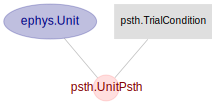

In [50]:
upsth_erd

In [51]:
psth.TrialCondition()

trial_condition_name user-friendly name of condition,trial_condition_hash trial condition hash - hash of func and arg,trial_condition_func trial retrieval function,trial_condition_arg trial retrieval arguments
all_noearlylick_both_alm_nostim,9dbe618e8775ba08855a779ddb98e469,_get_trials_exclude_stim,=BLOB=
all_noearlylick_both_alm_nostim_left,098bfce10178eadb5821d7cdbd22321d,_get_trials_exclude_stim,=BLOB=
all_noearlylick_both_alm_nostim_right,6263635bae2d5185640fd58aeaae8632,_get_trials_exclude_stim,=BLOB=
all_noearlylick_both_alm_stim,910cfcd39d7a1752616d38a009e23434,_get_trials_include_stim,=BLOB=
all_noearlylick_both_alm_stim_left,b19705e539f7b94bf1d620f06c52c935,_get_trials_include_stim,=BLOB=
all_noearlylick_both_alm_stim_right,b51fdd205268f30ffdf1e5e85c67fe24,_get_trials_include_stim,=BLOB=
good_noearlylick_hit,736552c7bdc75be3adea79297dcedcce,_get_trials_exclude_stim,=BLOB=
good_noearlylick_left_hit,6210474348cdfd0cdd9cc35c6b8b7238,_get_trials_exclude_stim,=BLOB=
good_noearlylick_left_miss,03c3f0aabc85e62bf396479206a37546,_get_trials_exclude_stim,=BLOB=
good_noearlylick_right_hit,4ac0ca959157d01adfc948eefd9561e8,_get_trials_exclude_stim,=BLOB=


In [52]:
unit_psth = psth.UnitPsth * psth.TrialCondition & unit_key & 'trial_condition_name = "good_noearlylick_hit"'

In [53]:
psth_trace, edges = unit_psth.fetch1('unit_psth')

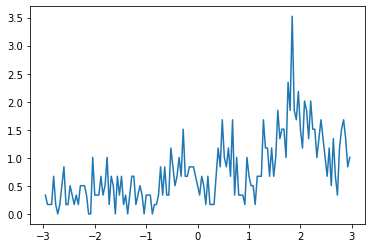

In [54]:
plt.plot(edges[1:], psth_trace)

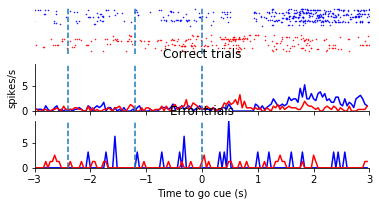

In [55]:
plot.unit_psth(unit_key)

# ================================================